Predict the price of the Uber ride from a given pickup point to the agreed drop-off location.
Perform following tasks:
1. Pre-process the dataset.
2. Identify outliers.
3. Check the correlation.
4. Implement linear regression and random forest regression models.
5. Evaluate the models and compare their respective scores like R2, RMSE, etc.
Dataset link: https://www.kaggle.com/datasets/yasserh/uber-fares-dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
#from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_score, recall_score
# , plot_precision_recall_curve, plot_roc_curve

In [3]:
df=pd.read_csv('./uber.csv')

In [4]:
df.isnull().sum()

Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [5]:
df['dropoff_longitude'].fillna(df['dropoff_longitude'].mean(),inplace=True)
df['dropoff_latitude'].fillna(df['dropoff_latitude'].mean(),inplace=True)

C:\Users\purva\AppData\Local\Temp\ipykernel_14768\121251366.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['dropoff_longitude'].fillna(df['dropoff_longitude'].mean(),inplace=True)
C:\Users\purva\AppData\Local\Temp\ipykernel_14768\121251366.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

In [6]:
df.drop(labels='Unnamed: 0',axis=1,inplace=True)
df.drop(labels='key',axis=1,inplace=True)

In [7]:
df.isnull().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [8]:
df.dtypes

fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

<Axes: xlabel='dropoff_latitude'>

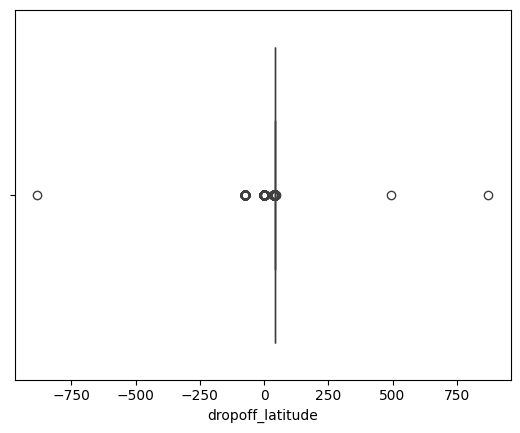

In [9]:
sns.boxplot(x= df['dropoff_latitude'])

<Axes: xlabel='fare_amount'>

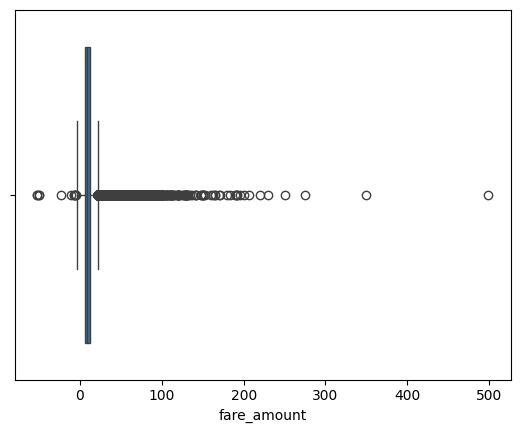

In [10]:
sns.boxplot(x=df['fare_amount'])

In [11]:
def find_outliers_IQR(df):
   q1 = df.quantile(0.25)
   q3 = df.quantile(0.75)
   IQR = q3-q1
   outliers = df[((df<(q1-1.5*IQR)) | (df>(q3+1.5*IQR)))]
   return outliers

In [12]:
outliers = find_outliers_IQR(df["fare_amount"])
print("number of outliers: "+ str(len(outliers)))
print("max outlier value: "+ str(outliers.max()))
print("min outlier value: "+ str(outliers.min()))
outliers

number of outliers: 17167
max outlier value: 499.0
min outlier value: -52.0


6         24.50
30        25.70
34        39.50
39        29.00
48        56.80
          ...  
199976    49.70
199977    43.50
199982    57.33
199985    24.00
199997    30.90
Name: fare_amount, Length: 17167, dtype: float64

In [13]:
outliers = find_outliers_IQR(df["pickup_latitude"])
print("number of outliers: "+ str(len(outliers)))
print("max outlier value: "+ str(outliers.max()))
print("min outlier value: "+ str(outliers.min()))
outliers

number of outliers: 9424
max outlier value: 1644.421482
min outlier value: -74.01551500000001


7          0.000000
11         0.000000
30        40.834367
34        40.642187
53        40.850558
            ...    
199917    40.656939
199926    40.644417
199960    40.847114
199963     0.000000
199972    40.639842
Name: pickup_latitude, Length: 9424, dtype: float64

In [14]:
df = df[
    (df.pickup_latitude > -90) & (df.pickup_latitude < 90) &
    (df.dropoff_latitude > -90) & (df.dropoff_latitude < 90) &
    (df.pickup_longitude > -180) & (df.pickup_longitude < 180) &
    (df.dropoff_longitude > -180) & (df.dropoff_longitude < 180) &
    (df.fare_amount > 0) &
    (df.passenger_count > 0) & (df.passenger_count < 50)
]

In [15]:
df.info

<bound method DataFrame.info of         fare_amount          pickup_datetime  pickup_longitude  \
0               7.5  2015-05-07 19:52:06 UTC        -73.999817   
1               7.7  2009-07-17 20:04:56 UTC        -73.994355   
2              12.9  2009-08-24 21:45:00 UTC        -74.005043   
3               5.3  2009-06-26 08:22:21 UTC        -73.976124   
4              16.0  2014-08-28 17:47:00 UTC        -73.925023   
...             ...                      ...               ...   
199995          3.0  2012-10-28 10:49:00 UTC        -73.987042   
199996          7.5  2014-03-14 01:09:00 UTC        -73.984722   
199997         30.9  2009-06-29 00:42:00 UTC        -73.986017   
199998         14.5  2015-05-20 14:56:25 UTC        -73.997124   
199999         14.1  2010-05-15 04:08:00 UTC        -73.984395   

        pickup_latitude  dropoff_longitude  dropoff_latitude  passenger_count  
0             40.738354         -73.999512         40.723217                1  
1             4

In [16]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [17]:
def haversine(lat1,lon1,lat2,lon2):
    lat1,lon1,lat2,lon2=map(np.radians,[lat1,lon1,lat2,lon2])
    dlat=lat2-lat1
    dlon=lon2-lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c=2*np.arcsin(np.sqrt(a))
    return 6371 * c
df['distance']=haversine(df['pickup_latitude'],df['pickup_longitude'],df['dropoff_latitude'],df['dropoff_longitude'])

In [18]:
df['distance']=haversine(df['pickup_latitude'],df['pickup_longitude'],df['dropoff_latitude'],df['dropoff_longitude'])

In [19]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,1.683323
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,2.457590
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,5.036377
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,1.661683
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,4.475450


In [20]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,1.683323
1,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,2.457590
2,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,5.036377
3,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,1.661683
4,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,4.475450


<Axes: xlabel='distance'>

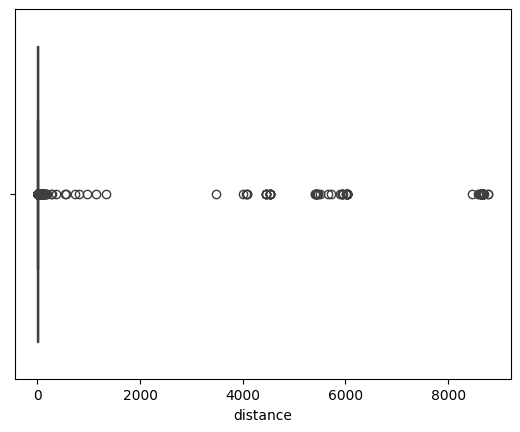

In [21]:
sns.boxplot(x= df['distance'])

<Axes: xlabel='distance'>

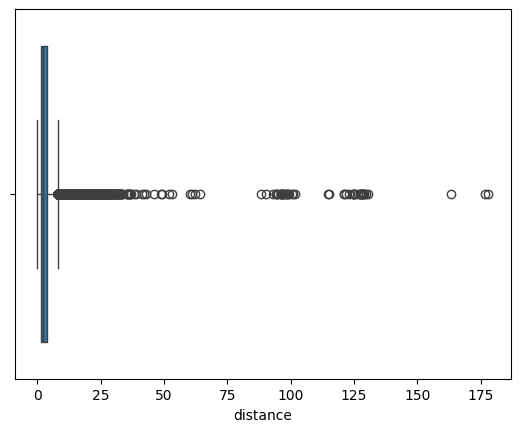

In [22]:
df = df[(df['distance'] > 0) & (df['distance'] < 200)]
sns.boxplot(x=df['distance'])

In [23]:
df.drop(columns=['pickup_datetime', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], inplace=True)

C:\Users\purva\AppData\Local\Temp\ipykernel_14768\3450893677.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['pickup_datetime', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], inplace=True)



Correlation Matrix:
                 fare_amount  passenger_count  distance
fare_amount         1.000000         0.011884  0.778667
passenger_count     0.011884         1.000000  0.005112
distance            0.778667         0.005112  1.000000


<Axes: xlabel='distance', ylabel='fare_amount'>

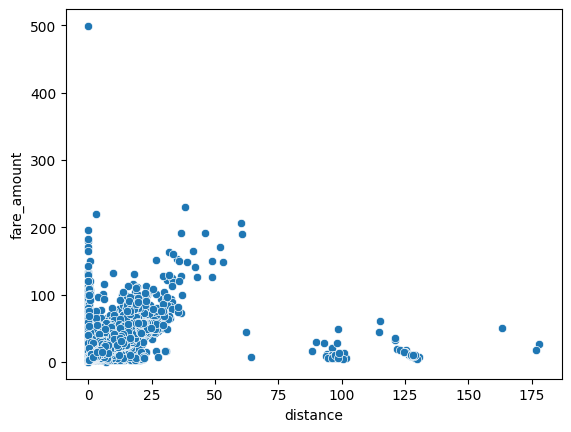

In [24]:
print("\nCorrelation Matrix:")
print(df.corr())

# Visualize the relationship between 'Distance' and 'fare_amount'
sns.scatterplot(x='distance', y='fare_amount', data=df)

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [26]:
X = df[['distance']]
y = df['fare_amount']

# Splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)


In [27]:
model=LinearRegression()

In [28]:
model.fit(X_train, y_train)

LinearRegression()

In [29]:
y_pred = model.predict(X_test)

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate R-squared (R²)
r2 = r2_score(y_test, y_pred)
print("R-squared (R²):", r2)


Mean Absolute Error (MAE): 2.6763078937374583
Mean Squared Error (MSE): 34.212779288800434
Root Mean Squared Error (RMSE): 5.849169110976399
R-squared (R²): 0.6218179344464185


C:\Users\purva\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [31]:
model_r=RandomForestRegressor(n_estimators=100, random_state=42)

In [32]:
model_r.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [33]:
y_pred_3 = model_r.predict(X_test)

In [34]:
r_squared = r2_score(y_test, y_pred_3)
print(r_squared)

0.6802765533457847


In [35]:
rmse = mean_squared_error(y_test, y_pred_3, squared=False)
mae = mean_absolute_error(y_test, y_pred_3)
print(rmse)
print(mae)

5.378125793853084
2.8424548227146262


C:\Users\purva\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [36]:
# Example distance value (in kilometers) for prediction
input_distance = 10.0  # Replace this with the distance you want to predict for

# 1. Prepare the input for prediction
# Create a DataFrame with the distance value
input_data = pd.DataFrame({'distance': [input_distance]})

# 2. Scale the input data using the previously fitted scaler
scaled_input = scaler_X.transform(input_data)

# 3. Make predictions using both models
predicted_fare_lr = model.predict(scaled_input)
predicted_fare_rf = model_r.predict(scaled_input)

# 4. Output the predicted fare
print(f"Predicted fare using Linear Regression for {input_distance} km: ${predicted_fare_lr[0]:.2f}")
print(predicted_fare_lr)
print(f"Predicted fare using Random Forest Regression for {input_distance} km: ${predicted_fare_rf[0]:.2f}")


Predicted fare using Linear Regression for 10.0 km: $23.75
[23.75234706]
Predicted fare using Random Forest Regression for 10.0 km: $30.86
